## Extension : Data Augmententation ##

A first draft of the neural network that will be used for the ECG classification project is described in this notebook.

### Initialization ###

We will train our model  with the help of the TensorFlow framework. If you had not installed TensorFlow yet, you can do it easily with the command pip install --upgrade tensorflow.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras

import sys
sys.path.append("..") 
sys.path.append("../") 
import tools.modtester as test

### Part 1 : importing the data and pre-processing the datas ###

We start by importing our tests data. 

#### Converting to Black and White ####

In order to avoid a cheating model, we convert our images to B&W. 
This has been done in the convect_im2bw.py.

#### Balancing the number of datas ####

For now, we have this data distribution :
F : 803
M : 10506
N : 94635
Q : 8039
S : 2779
V : 7236

As a first step, we have 'manually' set up the number of images per category by hand. The most under-represented category is category F with only 803 sample images. We have decided to use several times images from this category to achieve 2000 sampling datas from each category. 

The accuracy achieved from this first training is 0.9942 (training accuracy) and 0.9621 (validation accuracy).

We would now like use some augmentation methods to try on a bigger and balanced dataset to gain more accuracy. 

A new augmented dataset has been generated thanks to the AugMix python files in createaugmentations.py.


In [21]:
traindata=tf.keras.utils.image_dataset_from_directory(
  #"Full_dataset\ECG_Image_data_cb_bw",
  #"Small_dataset\S_datas_labels_cb_bw",
  #"M_dataset\S_datas_labels_bw_bal2000",
  "M_dataset\S_datas_labels_augmented5000", # ENTER AUGMENTED DATASET
  labels='inferred',
  class_names=["F","M","N","Q","S","V"],
  validation_split=0.2,
  subset="training",
  color_mode="rgb",
  seed=123)

valdata=tf.keras.utils.image_dataset_from_directory(
  #"Full_dataset\ECG_Image_data_cb_bw",
  #"Small_dataset\S_datas_labels_cb_bw",
  #"M_dataset\S_datas_labels_bw_bal2000",
  "M_dataset\S_datas_labels_augmented5000",
  labels='inferred',
  class_names=["F","M","N","Q","S","V"],
  validation_split=0.2,
  subset="validation",
  color_mode="rgb",
  seed=123)


plt.figure(figsize=(10, 10))
for images, labels in traindata.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(traindata.class_names[labels[i]])
    plt.axis("off")



NotFoundError: Could not find directory M_dataset\S_datas_labels_augmented5000

#### Data standardization ###

For now, RVB channels are in [0,255] which is too large for a neural network. We will then normalize these values. 

NOTE : use only one channel for black and white pictures : search code to convert to black and white.

NOTE 2 :  Rescaling the image can be directly implemented in the model by layer.Rescaling

In [ ]:
normalization_layer= tf.keras.layers.Rescaling(1./255)

normtraindata=traindata.map(lambda x, y: (normalization_layer(x),y))
valtraindata=valdata.map(lambda x, y: (normalization_layer(x),y))

### Part 2 :  creating the model ###

In this part, we define important elements that will be used to build our model. 

NOTE : This model is the one used in the Image Classification tutorial from TensorFlow website, same for the compiler. NEED TO BE RETHINKED AND DISCUSSED. 

PADDING : start with 'Valid' --> 'Same', keep as much information as possible

ACTIVATION function : can be changed also 

FLATTEN : flattening/mapping the pixels

POOLING : change between Max/Average ?

In [ ]:
# Model Creation
model=keras.Sequential([  ### THE EASIER MODEL THAT CAN BE TESTED
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'), 
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.5), #NEW LAYER to avoid overfitting
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(6)
])

model1= keras.Sequential([ ### KEEP IN MEMORY LAST MODEL
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'), 
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.5), #NEW LAYER to avoid overfitting
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(), #NEW LAYER to avoid overfitting
    keras.layers.Dense(6)
])

model.build((None,256,256,3))

opt = keras.optimizers.Adam(learning_rate=1e-04)

#Model Compiler
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Model summary 
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

### Part 3 : training and testing ###

Note : This code is taken from the TensorFlow tutorial page. 

Epoch 1/10
750/750 [==============================] - 1346s 2s/step - loss: 0.7087 - accuracy: 0.7526 - val_loss: 0.3881 - val_accuracy: 0.8862
Epoch 2/10
750/750 [==============================] - 1515s 2s/step - loss: 0.3156 - accuracy: 0.9012 - val_loss: 0.2656 - val_accuracy: 0.9208
Epoch 3/10
750/750 [==============================] - 1277s 2s/step - loss: 0.2338 - accuracy: 0.9279 - val_loss: 0.2263 - val_accuracy: 0.9292
Epoch 4/10
750/750 [==============================] - 1243s 2s/step - loss: 0.1860 - accuracy: 0.9409 - val_loss: 0.1930 - val_accuracy: 0.9437
Epoch 5/10
750/750 [==============================] - 1244s 2s/step - loss: 0.1490 - accuracy: 0.9533 - val_loss: 0.1678 - val_accuracy: 0.9502
Epoch 6/10
750/750 [==============================] - 1247s 2s/step - loss: 0.1257 - accuracy: 0.9610 - val_loss: 0.1611 - val_accuracy: 0.9503
Epoch 7/10
750/750 [==============================] - 1236s 2s/step - loss: 0.1063 - accuracy: 0.9659 - val_loss: 0.1554 - val_accuracy:

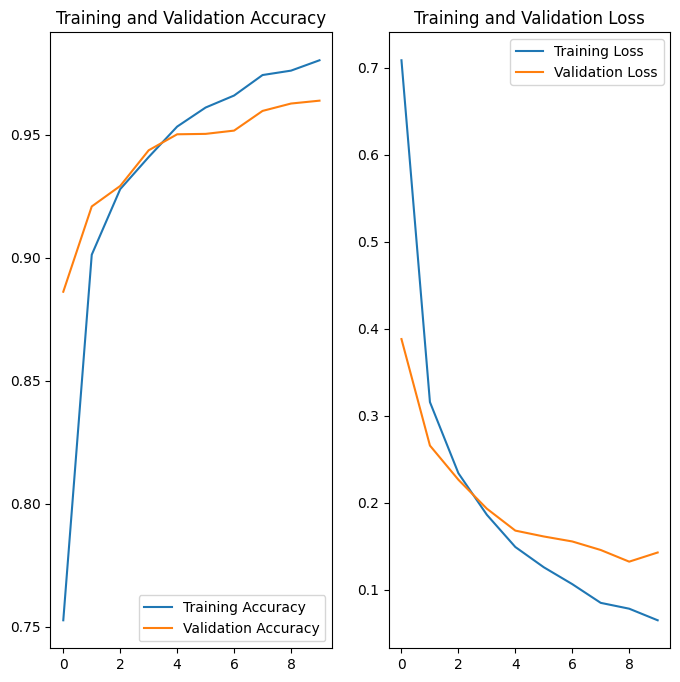

In [ ]:
epochs= 20
history = model.fit(
  normtraindata,
  validation_data=valtraindata,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

model.save("model/model_small_augmented.h5")

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



### Part 4 : Testing a random image on the model ###

Very simple code to quickly test some predictions on our model. Has to be improved. 

Found 144 files belonging to 6 classes.
Found 32 files belonging to 6 classes.
7/7 [==============================] - 1s 52ms/step
Image 0 || Predicted Disease : F || True Disease : F
Image 1 || Predicted Disease : F || True Disease : F
Image 2 || Predicted Disease : F || True Disease : F
Image 3 || Predicted Disease : F || True Disease : F
Image 4 || Predicted Disease : F || True Disease : F
Image 5 || Predicted Disease : M || True Disease : M
Image 6 || Predicted Disease : M || True Disease : M
Image 7 || Predicted Disease : M || True Disease : M
Image 8 || Predicted Disease : M || True Disease : M
Image 9 || Predicted Disease : M || True Disease : M
Image 10 || Predicted Disease : M || True Disease : M
Image 11 || Predicted Disease : N || True Disease : N
Image 12 || Predicted Disease : N || True Disease : N
Image 13 || Predicted Disease : N || True Disease : N
Image 14 || Predicted Disease : N || True Disease : N
Image 15 || Predicted Disease : N || True Disease : N
Image 16 || Pre

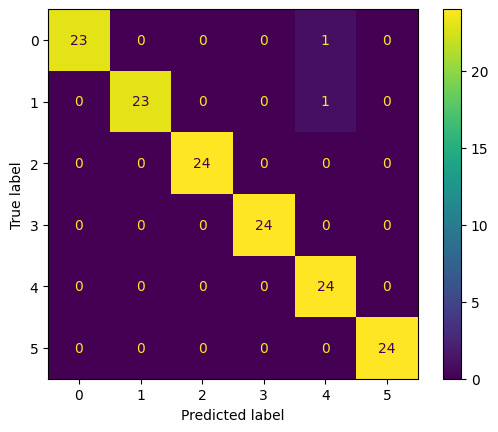

In [ ]:
test.directmodeltest(model,False)
